### Carga de librerias necesarias para el analisis multivariante

In [107]:

#==============================================================================
# EJEMPLO DEL MÉTODO DE ANALISIS DE COMPONENETES PRINCIPALES
#==============================================================================

# Cargar librerías
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,  roc_auc_score, roc_curve
import warnings
from sklearn.exceptions import ConvergenceWarning

### Se carga el dataset 
# Predict the Introverts from the Extroverts

### Este dataset contiene una colección de rasgos de comportamiento social y personalidad de diferentes individuos. Incluye 7 variables predictoras (como Time_spent_Alone, Stage_fear, Social_event_attendance, etc.) y una variable objetivo categórica, Personality.

### Su utilidad es para un problema de clasificación binaria: el objetivo es entrenar un modelo de machine learning (como Regresión Logística) que aprenda los patrones en las 7 variables de comportamiento para predecir si un individuo es "Introvertido" o "Extrovertido".

### Diccionario de Datos: Predicción de Personalidad

| Variable | Tipo | Descripción | Valores / Ejemplo |
| :--- | :--- | :--- | :--- |
| **id** | Numérica | 🆔 ID único para cada participante en la encuesta. | 0, 1, 2, ... |
| **Time\_spent\_Alone** | Numérica (Discreta) | ⏳ Horas promedio que la persona reporta pasar sola al día. | 0.0, 1.0, 6.0, ... |
| **Stage\_fear** | Categórica (Binaria) | 🎭 Indica si la persona reporta tener miedo escénico. | 'Yes', 'No' |
| **Social\_event\_attendance** | Numérica (Discreta) | 🥳 Frecuencia de asistencia a eventos sociales (escala/conteo). | 6.0, 7.0, 1.0, ... |
| **Going\_outside** | Numérica (Discreta) | 🏞️ Frecuencia con la que la persona reporta salir (escala/conteo). | 4.0, 3.0, 0.0, ... |
| **Drained\_after\_socializing**| Categórica (Binaria) | 🔋 Indica si la persona reporta sentirse agotada después de socializar. | 'Yes', 'No' |
| **Friends\_circle\_size** | Numérica (Discreta) | 👥 Tamaño reportado del círculo de amigos (escala/conteo). | 15.0, 10.0, 3.0, ... |
| **Post\_frequency** | Numérica (Discreta) | 📱 Frecuencia reportada de publicación en redes sociales (escala/conteo). | 5.0, 8.0, 0.0, ... |
| **Personality** | Categórica (Binaria) | 🎯 El rasgo de personalidad.<br>*Variable objetivo a predecir.* | 'Extrovert', 'Introvert' |


### Paso 1: Carga, Exploración y Limpieza de Datos

Cargamos los archivos del Dataset "Predicción de Personalidad" `train.csv` y `test.csv`realizamos la inspección inicial (nulos y duplicados).

In [93]:
df = pd.read_csv('./train.csv') # Cargar dataset
df_test=pd.read_csv('./test.csv')
df.head()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [94]:
# --- Conteo de Duplicados ---
duplicate_count = df.duplicated().sum()
print(f"\n--- Conteo de Duplicados ---")
print(f"Se encontraron {duplicate_count} filas duplicadas.")

# --- Limpieza de Duplicados ---
# Como Data Scientist, es crucial eliminar duplicados para un análisis estadístico válido.
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Duplicados eliminados. Nuevo shape: {df.shape}")


--- Conteo de Duplicados ---
Se encontraron 0 filas duplicadas.


In [95]:
# --- Análisis de la Variable Objetivo 'Class' ---
print("\n--- Análisis de la Variable Objetivo (Target) 'Personality' ---")
if 'Personality' in df.columns:
    num_classes = df['Personality'].nunique()
    print(f"Número de clases únicas (k): {num_classes}")
    print("\nDistribución de clases:")
    print(df['Personality'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))
else:
    print("¡ERROR! No se encontró la columna 'Class', necesaria para LDA.")


--- Análisis de la Variable Objetivo (Target) 'Personality' ---
Número de clases únicas (k): 2

Distribución de clases:
Personality
Extrovert    73.95%
Introvert    26.05%
Name: proportion, dtype: object


In [96]:
# --- Análisis de la Variables tipo Object ---
print(df['Stage_fear'].unique())
print(df['Drained_after_socializing'].unique())

['No' 'Yes' nan]
['No' nan 'Yes']


In [97]:
# --- Transformamos las variables tipo Object a numerica usando Maping ---
mapping = {'Yes': 1, 'No': 0}
df['Stage_fear'] = df['Stage_fear'].map(mapping)

mapping1 = {'Yes': 1, 'No': 0}
df['Drained_after_socializing'] = df['Drained_after_socializing'].map(mapping1)

mapping2 = {'Extrovert': 1, 'Introvert': 0}
df['Personality'] = df['Personality'].map(mapping2)

df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0.0,6.0,4.0,0.0,15.0,5.0,1
1,1,1.0,0.0,7.0,3.0,0.0,10.0,8.0,1
2,2,6.0,1.0,1.0,0.0,NaN,3.0,0.0,0
3,3,3.0,0.0,7.0,3.0,0.0,11.0,5.0,1
4,4,1.0,0.0,4.0,4.0,0.0,13.0,NaN,1


In [98]:
print(f"Dimensiones originales (filas, columnas): {df.shape}")
print("\n--- Inspección de Tipos y Nulos (df.info()) ---")
df.info()

Dimensiones originales (filas, columnas): (18524, 9)

--- Inspección de Tipos y Nulos (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  float64
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  float64
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.3 MB


In [99]:
# --- Imputacion de valores con KNN para los valores faltantes
num_cols = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
            'Going_outside', 'Drained_after_socializing',
            'Friends_circle_size', 'Post_frequency']

imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [100]:
df.isnull().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

### Paso 2: Preprocesamiento de Datos con PCA

PCA es un método supervisado y tieneutilidades clave:
1.  **Componentes principales:** Transforma las variables correlacionadas en un nuevo conjunto de variables que son matemáticamente no correlacionadas y resumen los patrones de los datos.
2.  **Reduccion de dimensionalidad:** creando un dataset más pequeño y denso (X_pca) que es más fácil de procesar para un modelo de clasificación y reduce el riesgo de sobreajuste.
3.  **Identificación de Características Dominantes:** Feature_importance identifica cuáles de las variables originales son las que más definen los patrones de comportamiento en tus datos. Esto te permite, por ejemplo, justificar la construcción de un modelo de clasificación mucho más simple utilizando solo las características más importantes en lugar de las 7

In [101]:
num_cols = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
            'Going_outside', 'Drained_after_socializing',
            'Friends_circle_size', 'Post_frequency']

X = df[num_cols]

pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X)

loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=num_cols)

explained_var = pca.explained_variance_ratio_

feature_importance = (abs(loadings) * explained_var).sum(axis=1).sort_values(ascending=False)

print("Overall Feature Importance after 90% variance PCA:")
print(feature_importance)

Overall Feature Importance after 90% variance PCA:
Post_frequency               0.348631
Social_event_attendance      0.339500
Friends_circle_size          0.338742
Going_outside                0.337662
Drained_after_socializing    0.327364
Stage_fear                   0.327162
Time_spent_Alone             0.305478
dtype: float64


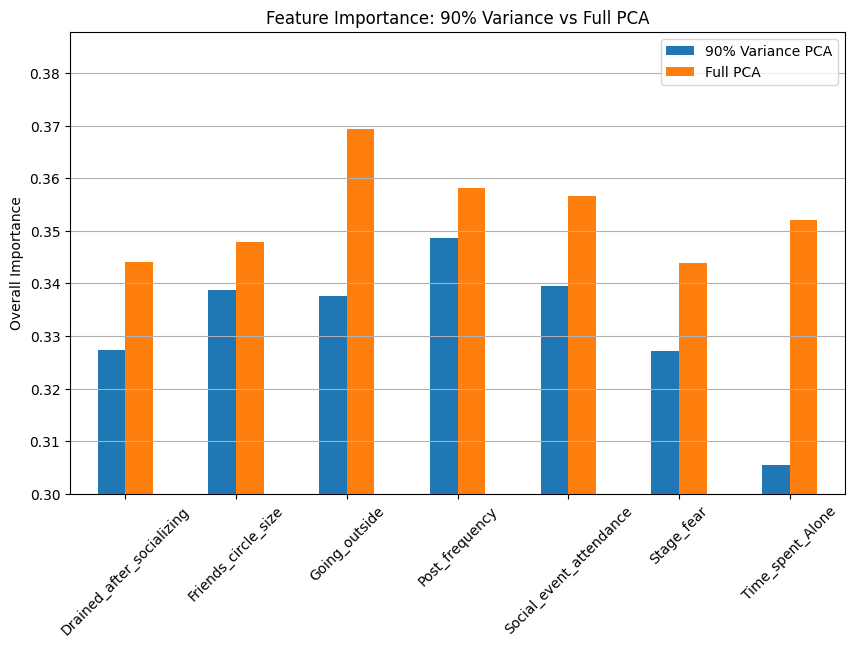

In [102]:
# --- Graficamos la importancia de las variables una ves aplicado PCA ---
num_cols = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
            'Going_outside', 'Drained_after_socializing',
            'Friends_circle_size', 'Post_frequency']

X = df[num_cols]

pca_90 = PCA(n_components=0.90)
X_pca_90 = pca_90.fit_transform(X)

loadings_90 = pd.DataFrame(pca_90.components_.T,
                           columns=[f'PC{i+1}' for i in range(pca_90.n_components_)],
                           index=num_cols)

explained_var_90 = pca_90.explained_variance_ratio_

feature_importance_90 = (abs(loadings_90) * explained_var_90).sum(axis=1)

pca_full = PCA()
X_pca_full = pca_full.fit_transform(X)

loadings_full = pd.DataFrame(pca_full.components_.T,
                             columns=[f'PC{i+1}' for i in range(pca_full.n_components_)],
                             index=num_cols)

explained_var_full = pca_full.explained_variance_ratio_

feature_importance_full = (abs(loadings_full) * explained_var_full).sum(axis=1)

df_plot = pd.DataFrame({
    '90% Variance PCA': feature_importance_90,
    'Full PCA': feature_importance_full
}).sort_index()

df_plot.plot(kind='bar', figsize=(10,6))
plt.title('Feature Importance: 90% Variance vs Full PCA')
plt.ylabel('Overall Importance')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylim(0.30, None)
plt.show()

In [106]:
# --- Implementacion de algoritmo de REGRESION LOGISTICA
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', message=".*suggest_loguniform.*")

num_cols = [
    'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
    'Going_outside', 'Drained_after_socializing',
    'Friends_circle_size', 'Post_frequency'
]

X = df[num_cols]
y = df['Personality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    penalty = 'l2'  
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=2000,
        random_state=42
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

warnings.filterwarnings('default')

print("\nBest Hyperparameters:")
print(study.best_params)

best_params = study.best_params
best_model = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    penalty='l2',
    class_weight=best_params['class_weight'],
    max_iter=2000,
    random_state=42
)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("\nModel Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[I 2025-11-08 14:51:55,778] A new study created in memory with name: no-name-d7cc4b33-a4c0-41e6-86e3-80de10afe553


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-08 14:51:55,931] Trial 0 finished with value: 0.9604497422334262 and parameters: {'C': 3.893296602772412, 'solver': 'liblinear', 'class_weight': None}. Best is trial 0 with value: 0.9604497422334262.
[I 2025-11-08 14:51:56,123] Trial 1 finished with value: 0.9605396620373178 and parameters: {'C': 0.7871492196300615, 'solver': 'liblinear', 'class_weight': None}. Best is trial 1 with value: 0.9605396620373178.
[I 2025-11-08 14:51:56,279] Trial 2 finished with value: 0.9605732756056493 and parameters: {'C': 0.43252911309170444, 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9605732756056493.
[I 2025-11-08 14:51:56,436] Trial 3 finished with value: 0.9605732756056493 and parameters: {'C': 4.413332042253748, 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.9605732756056493.
[I 2025-11-08 14:51:56,654] Trial 4 finished with value: 0.9606327681138266 and parameters: {'C': 0.7996101664425583, 'solver': 'lbfgs', 'cla

ROC-AUC Score: 0.9496


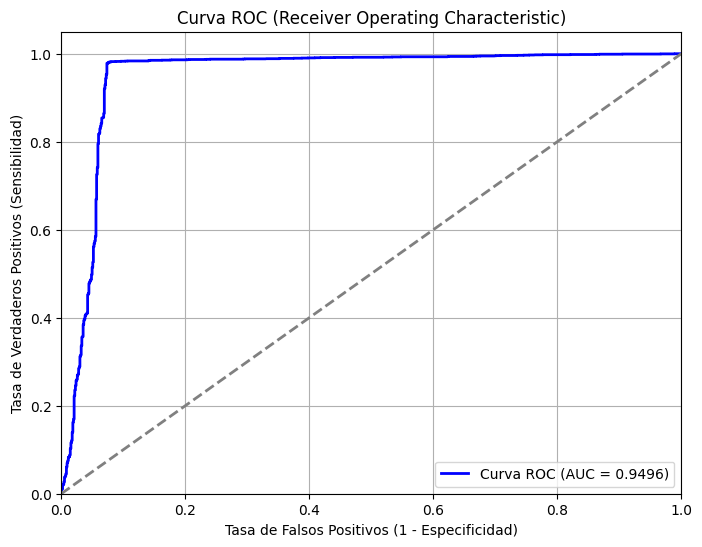

In [108]:
# --- 1. Obtener las Probabilidades ---
# Calcula las probabilidades de la clase positiva (1)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# --- 2. Calcular el puntaje ROC-AUC ---
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {auc:.4f}")

# --- 3. Calcular la Curva ROC ---
# Obtenemos la Tasa de Falsos Positivos (fpr) y la Tasa de Verdaderos Positivos (tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# --- 4. Graficar la Curva ROC ---
plt.figure(figsize=(8, 6))
# Grafica la curva ROC
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc:.4f})')
# Grafica la línea de referencia (azar)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# --- Títulos y Etiquetas ---
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()